In [1]:
from skimage.filters import threshold_local
import numpy as np
import argparse
import cv2
import imutils
import matplotlib.pyplot as plt

In [2]:
# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread('00096.jpg')
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

In [3]:
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

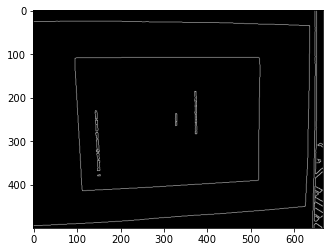

In [4]:
plt.imshow(edged, cmap='gray')

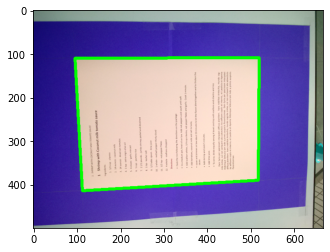

In [5]:
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        break

cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 5)
plt.imshow(image, cmap='gray')

In [6]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([[0, 0],[maxWidth - 1, 0],[maxWidth - 1, maxHeight - 1],[0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

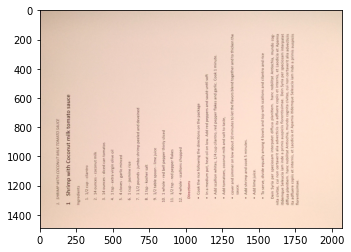

In [7]:
# apply the four point transform to obtain a top-down
# view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
plt.imshow(warped)

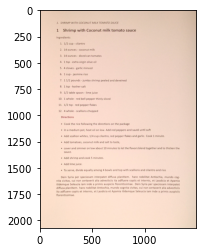

In [8]:
# rotate image
out=cv2.transpose(warped)
out=cv2.flip(out,flipCode=1)

plt.imshow(out)

In [9]:
plt.rcParams['figure.figsize'] = [9,9]

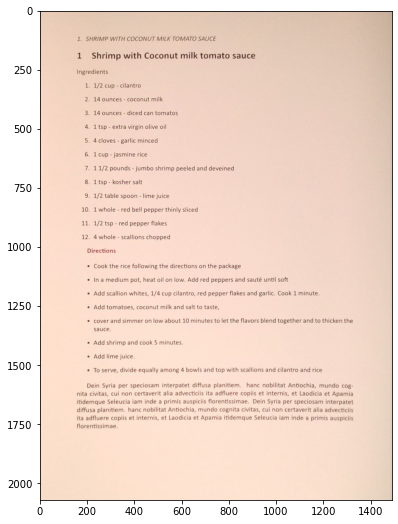

In [10]:
plt.imshow(out)

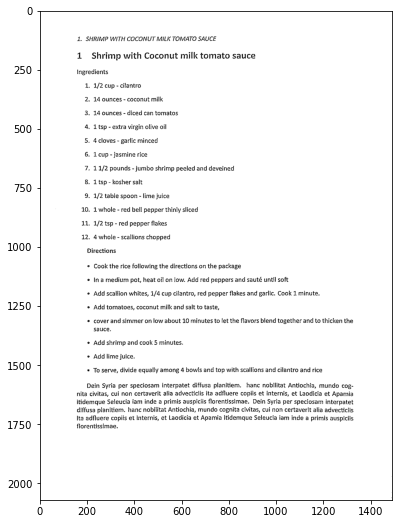

In [11]:
warped = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255
plt.imshow(warped, cmap='gray')

In [13]:
# save image
cv2.imwrite("test.jpg", warped)

True